# Tensorflow Lite examples

Install tensorflow 2 (check the proper version to install [here](https://www.tensorflow.org/install/pip))

In [0]:
!pip install tensorflow-gpu > /dev/null

ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.0.1 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.0.1 which is incompatible.
ERROR: tensorboard 2.0.1 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.7.0 which is incompatible.


In [0]:
!pip install "tensorflow_hub>=0.6.0" > /dev/null

In [0]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import numpy as np

import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm

print(f"Tensorflow version {tf.__version__}")

Tensorflow version 2.0.0


## Converting models into Tensorflow Lite

### Example 1: converting saved models

Get some data for the equation y = x - 1

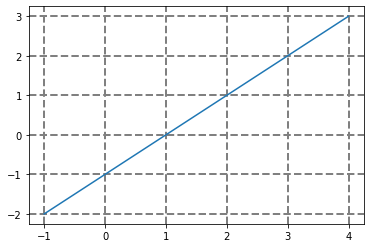

In [0]:
x = [-1, 0, 1, 2, 3, 4]
y = [-2, -1, 0, 1, 2, 3]
plt.plot(x, y)
plt.grid(color='gray', linestyle='--', linewidth=2)

Create a one layer keras model that will learn predicting y from x (i.e. a regression task)

In [0]:
layers = [tf.keras.layers.Dense(1, input_shape=[1])]
model = tf.keras.models.Sequential(layers)
model.compile('sgd', loss='mean_squared_error')
model.fit(x, y, epochs=100, verbose=0)

Check how well the model is behaving

In [0]:
model.predict(x)

array([[-1.4704936 ],
       [-0.5996334 ],
       [ 0.27122682],
       [ 1.142087  ],
       [ 2.0129473 ],
       [ 2.8838074 ]], dtype=float32)

Save the model

In [0]:
saved_model_dir = './output'

In [0]:
tf.saved_model.save(model, saved_model_dir)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./output/assets


Convert the model into TF Lite using `from_saved_model`

In [0]:
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

The output of the conversion is a byte array representing the model, let's store for future use

In [0]:
tflite_model_file = Path("./model.tflite")
open(tflite_model_file, 'wb').write(tflite_model)

780

Let's check how the new TF Lite model is behaving

### Example 2: converting Keras models

Let's use a pretrained Keras model from Tensorlfow Hub, e.g. [MobileNet](https://tfhub.dev/google/imagenet/mobilenet_v1_050_160/classification/4)

In [0]:
module_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
# use the model as a backbone for finetunning
backbone = hub.KerasLayer(module_url)
backbone.build([None, 224, 224, 3])

Let's fine tune this model on a small dataset (you can pick anyone from [Datasets Catalog](https://www.tensorflow.org/datasets/catalog/overview))

In [0]:
samples, info = tfds.load("caltech101", with_info=True)

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Dataset caltech101 downloaded and prepared to /root/tensorflow_datasets/caltech101/1.1.0. Subsequent calls will reuse this data.


In [0]:
print(info)

tfds.core.DatasetInfo(
    name='caltech101',
    version=1.1.0,
    description='Caltech-101 consists of pictures of objects belonging to 101 classes, plus
one `background clutter` class. Each image is labelled with a single object.
Each class contains roughly 40 to 800 images, totalling around 9k images.
Images are of variable sizes, with typical edge lengths of 200-300 pixels.
This version contains image-level labels only. The original dataset also
contains bounding boxes.
',
    urls=['http://www.vision.caltech.edu/Image_Datasets/Caltech101/'],
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/file_name': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=102),
    }),
    total_num_examples=9801,
    splits={
        'test': 6741,
        'train': 3060,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{FeiFei2004LearningGV,
      title={Learning Generative 

In [0]:
classes = info.features["label"].names

In [0]:
train_samples, test_samples = samples['train'], samples['test']

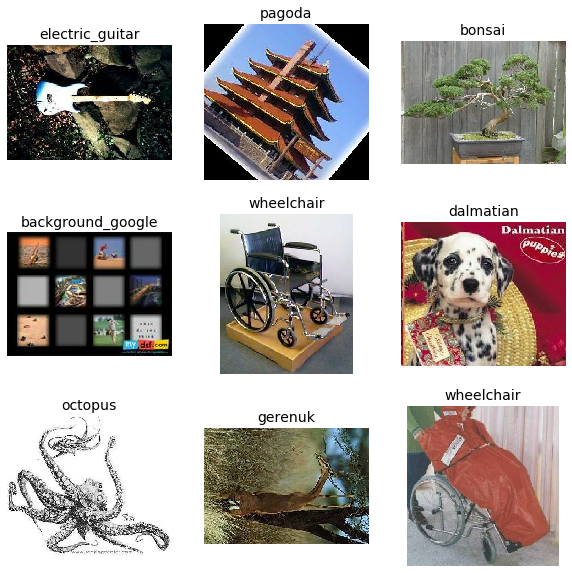

In [0]:
f = plt.figure(figsize=(10, 10))
for index, elem in enumerate(train_samples.take(9)):
  image, label_index = elem["image"], elem["label"].numpy()
  sp = f.add_subplot(3, 3, index + 1)
  sp.axis('off')
  sp.set_title(classes[label_index], fontsize=14)
  plt.imshow(image.numpy())

In [0]:
def normalize(row):
    image, label = row['image'], row['label']
    image = tf.dtypes.cast(image, tf.float32)
    image = tf.image.resize(image, (224, 224))
    image = image / 255.0
    return image, label

In [0]:
train_data = train_samples.repeat().shuffle(1024).map(normalize).batch(32).prefetch(1)
test_data = test_samples.map(normalize).batch(1)

In [0]:
model = tf.keras.Sequential([backbone, tf.keras.layers.Dense(len(classes), activation='softmax')])
model.build([None, 224, 224, 3])
model.compile('adam', loss='sparse_categorical_crossentropy')

In [0]:
model.fit_generator(train_data, epochs=1, steps_per_epoch=100)

100/100 [==============================] - 24s 237ms/step - loss: 2.1510


In [0]:
saved_model_dir = './output'
tf.saved_model.save(model, saved_model_dir)

INFO:tensorflow:Assets written to: ./output/assets


INFO:tensorflow:Assets written to: ./output/assets


After fine tuning the model, we can now convert it to TF Lite

In [0]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

Now we can save the TF Lite model for later use

In [0]:
tflite_model_file = './mobilenet_v2_caltech101.tflite'
open(tflite_model_file, 'wb').write(tflite_model)

9392900

Use a local interpreter to load the converted model

In [0]:
tflite_model_file = 'mobilenet_v2_caltech101.tflite'
with open(tflite_model_file, 'rb') as fid:
  tflite_model = fid.read()
  
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

Run the converted model against test data

In [0]:
predictions = []

test_labels, test_imgs = [], []
for image, label in tqdm(test_data.take(10)):
  interpreter.set_tensor(input_index, image)
  interpreter.invoke()
  predictions.append(interpreter.get_tensor(output_index))
  
  test_labels.append(label.numpy()[0])
  test_imgs.append(image)

10it [00:00, 11.81it/s]


Plot result

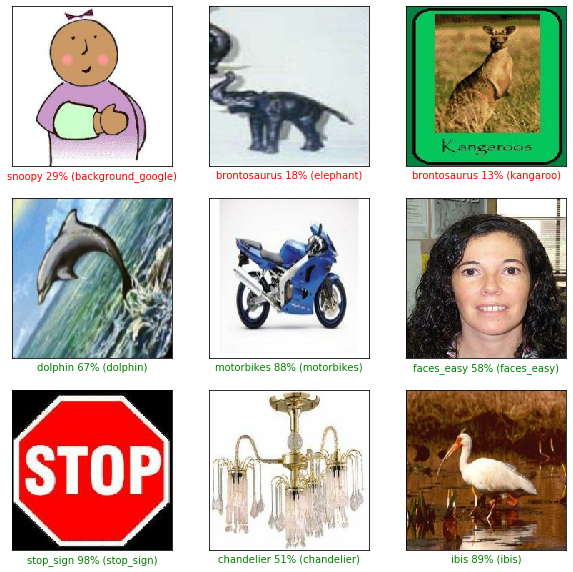

In [0]:
plt.figure(figsize=(10,10))
for (i, (predictions_array, true_label, image)) in enumerate(zip(predictions[:9], test_labels[:9], test_imgs[:9])):
  plt.subplot(3, 3, i+1)
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
    
  image = np.squeeze(image)

  plt.imshow(image, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'green'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(classes[predicted_label],
                                100*np.max(predictions_array),
                                classes[true_label]),
                                color=color)
plt.show()

Pretty good, isn't?

### Example 3: converting concrete functions

In [0]:
model = tf.keras.applications.MobileNetV2(weights='imagenet', input_shape=(224, 224, 3))

14540800/14536120 [==============================] - 2s 0us/step


Create a TF function that will call the model under the hood

In [0]:
run_model = tf.function(lambda x: model(x))
concrete_func = run_model.get_concrete_function(tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype))

Save the TF function 

In [0]:
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
tflite_model = converter.convert()

### Example 4: converting models from the CLI

Converting a SavedModel

In [0]:
!tflite_convert --output_file=model.tflite --saved_model_dir=/tmp/saved_model

Converting a Keras model

In [0]:
!tflite_convert --output_file=model.tflite --keras_model_file=model.h5